🧠 Loading EEG data from: dataset/eeg1.edf
Extracting EDF parameters from /Users/rash/Documents/Files/Self/College/Semester 5/Bio Signal Processing/Neonatal-Seizure-Prediction-EEG/dataset/eeg1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1790207  =      0.000 ...  6992.996 secs...
✅ EEG data loaded successfully.
<Info | 8 non-empty values
 bads: []
 ch_names: EEG Fp1-REF, EEG Fp2-REF, EEG F3-REF, EEG F4-REF, EEG C3-REF, ...
 chs: 21 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: 2011-11-11 11:11:11 UTC
 nchan: 21
 projs: []
 sfreq: 256.0 Hz
 subject_info: <subject_info | his_id: >
>
------------------------------
📝 Loading annotations from: dataset/annotations_2017.mat
⚠️ Warning: Odd number of annotation objects. Ignoring the last one.
✅ Found and processed 39 seizure annotations.
------------------------------
✅ Annotations have been successfully applied to the EEG data.

Annotation details:
<A

/var/folders/hf/lgxr763d0dx9wh5gzjxr233m0000gn/T/ipykernel_95741/1663067844.py:48: RuntimeWarning: overflow encountered in scalar subtract
  duration = end_time - start_time


Using matplotlib as 2D backend.
✅ Plot saved as 'eeg_with_annotations.png'


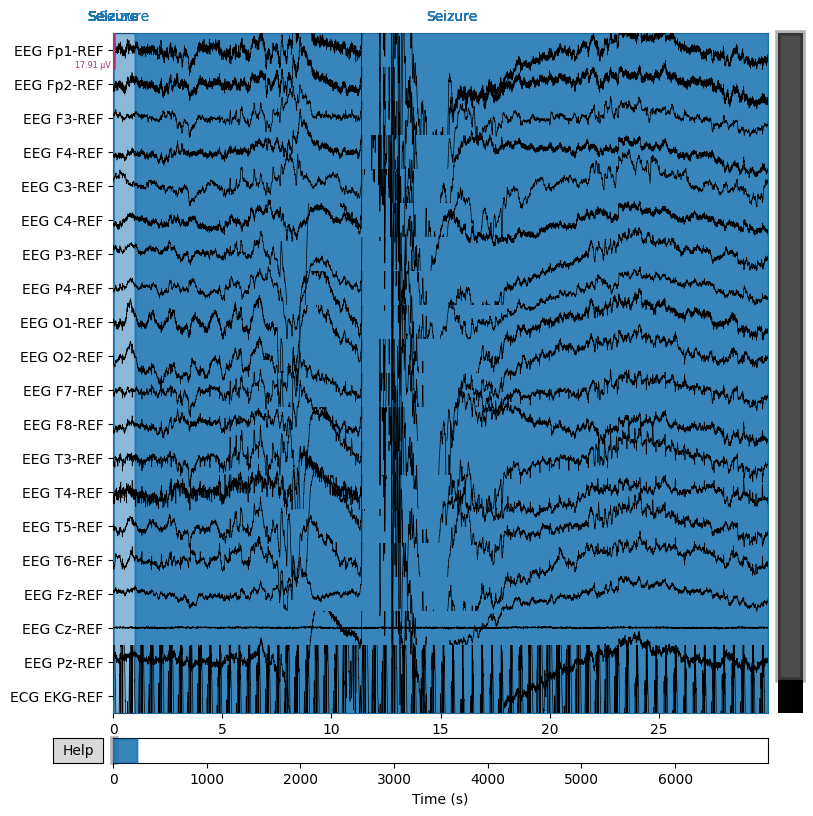

In [8]:
import mne
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

def load_eeg_with_annotations(edf_path, mat_path):
    """
    Loads an EEG file (.edf) and its corresponding seizure annotations
    from a MATLAB file (.mat), then integrates them using the MNE library.

    Args:
        edf_path (str): The file path for the EEG data in EDF format.
        mat_path (str): The file path for the annotations in .mat format.
    """
    try:
        # --- 1. Load the EEG Data using MNE ---
        print(f"🧠 Loading EEG data from: {edf_path}")
        # Preload=True loads the data into memory
        raw = mne.io.read_raw_edf(edf_path, preload=True)
        print("✅ EEG data loaded successfully.")
        print(raw.info)
        print("-" * 30)

        # --- 2. Load and Process Annotations from .mat File ---
        print(f"📝 Loading annotations from: {mat_path}")
        # squeeze_me=True simplifies the loaded .mat structure
        mat_data = scipy.io.loadmat(mat_path, squeeze_me=True)
        
        annotation_key = 'annotat_new'
        data_objects = mat_data[annotation_key]
        
        onsets = []
        durations = []
        descriptions = []

        num_objects = data_objects.size
        # Handle the odd number of elements by ignoring the last one
        if num_objects % 2 != 0:
            print("⚠️ Warning: Odd number of annotation objects. Ignoring the last one.")
            num_objects -= 1

        # Iterate through the objects in pairs (start, end)
        for i in range(0, num_objects, 2):
            # Each object is a NumPy array; we take the first element.
            start_time = data_objects[i].flatten()[0]
            end_time = data_objects[i+1].flatten()[0]
            
            duration = end_time - start_time
            
            # Only add valid, non-negative durations
            if duration >= 0:
                onsets.append(start_time)
                durations.append(duration)
                descriptions.append('Seizure') # Label for the annotation

        print(f"✅ Found and processed {len(onsets)} seizure annotations.")
        print("-" * 30)

        # --- 3. Create an MNE Annotations Object ---
        # MNE requires onsets, durations, and descriptions
        if onsets:
            annotations = mne.Annotations(onset=onsets,
                                          duration=durations,
                                          description=descriptions)

            # --- 4. Apply Annotations to the EEG Data ---
            raw.set_annotations(annotations)
            print("✅ Annotations have been successfully applied to the EEG data.")
            print("\nAnnotation details:")
            print(raw.annotations)
            print("-" * 30)

            # --- 5. Example Visualization ---
            print("📈 Generating a plot of the first 30 seconds of EEG data with annotations...")
            # Plot the first 30 seconds of data. Seizure annotations will be visible as shaded regions.
            # n_channels specifies how many channels to show at once.
            # scalings='auto' adjusts the y-axis for visibility.
            fig = raw.plot(start=0, duration=30, n_channels=20, scalings='auto', show=False)
            fig.savefig('eeg_with_annotations.png')
            print("✅ Plot saved as 'eeg_with_annotations.png'")

        else:
            print("No valid annotations were found to apply.")

    except FileNotFoundError as e:
        print(f"❌ Error: Could not find a file. Please check the path: {e.filename}")
    except Exception as e:
        print(f"❌ An unexpected error occurred: {e}")

# --- How to Use ---
# 1. Make sure you have the necessary libraries:
#    pip install mne scipy numpy matplotlib
#
# 2. Update the paths to your dataset files.
eeg_file_path = 'dataset/eeg1.edf'
annotation_file_path = 'dataset/annotations_2017.mat'

# 3. Run the function
load_eeg_with_annotations(eeg_file_path, annotation_file_path)

In [10]:
import mne
import scipy.io
import numpy as np
import pandas as pd

def export_eeg_for_training(edf_path, mat_path, n_baseline_portions=1000):
    """
    Loads EEG data and annotations, then exports seizure and a subset of
    non-seizure data to separate CSV files for machine learning.
    This version includes a fix for the 'Event time samples were not unique' error.

    Args:
        edf_path (str): The file path for the EEG data in EDF format.
        mat_path (str): The file path for the annotations in .mat format.
        n_baseline_portions (int): The number of non-seizure portions to export.
    """
    try:
        # --- 1. Load Data and Create Epochs ---
        print("🧠 Loading EEG data and annotations...")
        raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
        mat_data = scipy.io.loadmat(mat_path, squeeze_me=True)
        
        data_objects = mat_data['annotat_new']
        onsets, durations, descriptions = [], [], []
        
        num_objects = data_objects.size
        if num_objects % 2 != 0:
            num_objects -= 1
        
        for i in range(0, num_objects, 2):
            start_time = data_objects[i].flatten()[0]
            end_time = data_objects[i+1].flatten()[0]
            # The RuntimeWarning for overflow can occur if the numbers are very large,
            # but the logic remains sound. We proceed with the calculation.
            duration = end_time - start_time
            if duration > 0:
                onsets.append(start_time)
                durations.append(duration)
                descriptions.append('Seizure')

        if not onsets:
            print("❌ No annotations with a positive duration found. Cannot export data.")
            return

        annotations = mne.Annotations(onset=onsets, duration=durations, description=descriptions)
        raw.set_annotations(annotations)
        
        #
        # === THE FIX IS HERE ===
        # We add event_repeated='merge' to handle annotations at the same sample time.
        #
        events, event_id = mne.events_from_annotations(raw, event_repeated='merge')
        
        print("✅ Data and annotations loaded.")
        print("-" * 30)

        # --- 2. Extract and Save Seizure Data ---
        print("Processing seizure data...")
        if 'Seizure' in event_id:
            seizure_epochs = mne.Epochs(raw, events, event_id=event_id['Seizure'],
                                        tmin=0, tmax=np.max(durations), baseline=None, preload=True)
            
            seizure_data = seizure_epochs.get_data()
            
            n_epochs, n_channels, n_samples = seizure_data.shape
            seizure_data_reshaped = np.reshape(seizure_data, (n_epochs * n_samples, n_channels))
            
            df_seizure = pd.DataFrame(seizure_data_reshaped, columns=seizure_epochs.ch_names)
            df_seizure['label'] = 1
            
            df_seizure.to_csv('seizure_data.csv', index=False)
            print(f"✅ Saved {len(df_seizure)} rows of seizure data to 'seizure_data.csv'")
        else:
            print("⚠️ No 'Seizure' events found to export.")

        print("-" * 30)

        # --- 3. Extract and Save Non-Seizure (Baseline) Data ---
        print("Processing non-seizure data...")
        baseline_events = mne.make_fixed_length_events(raw, duration=1.0)
        baseline_epochs = mne.Epochs(raw, baseline_events, tmin=0, tmax=1.0, 
                                     baseline=None, preload=True, reject_by_annotation=True)
        
        if len(baseline_epochs) == 0:
            print("❌ Could not find any non-seizure portions to export.")
            return

        np.random.shuffle(baseline_epochs.selection)

        if len(baseline_epochs) < n_baseline_portions:
            print(f"⚠️ Warning: Found only {len(baseline_epochs)} non-seizure portions. Using all available.")
            n_baseline_portions = len(baseline_epochs)

        baseline_epochs_subset = baseline_epochs[:n_baseline_portions]
        
        baseline_data = baseline_epochs_subset.get_data()
        
        n_epochs, n_channels, n_samples = baseline_data.shape
        baseline_data_reshaped = np.reshape(baseline_data, (n_epochs * n_samples, n_channels))
        
        df_baseline = pd.DataFrame(baseline_data_reshaped, columns=baseline_epochs_subset.ch_names)
        df_baseline['label'] = 0
        
        df_baseline.to_csv('non_seizure_data.csv', index=False)
        print(f"✅ Saved {len(df_baseline)} rows from {n_baseline_portions} non-seizure portions to 'non_seizure_data.csv'")

    except FileNotFoundError as e:
        print(f"❌ Error: Could not find a file. Please check the path: {e.filename}")
    except Exception as e:
        print(f"❌ An unexpected error occurred: {e}")

# --- Paths to your dataset files ---
eeg_file_path = 'dataset/eeg1.edf'
annotation_file_path = 'dataset/annotations_2017.mat'

# --- Run the export process ---
export_eeg_for_training(eeg_file_path, annotation_file_path, n_baseline_portions=1000)

🧠 Loading EEG data and annotations...
❌ An unexpected error occurred: events_from_annotations() got an unexpected keyword argument 'event_repeated'


/var/folders/hf/lgxr763d0dx9wh5gzjxr233m0000gn/T/ipykernel_95741/2950024396.py:35: RuntimeWarning: overflow encountered in scalar subtract
  duration = end_time - start_time


In [14]:
import pandas as pd
import mne
import numpy as np
import os

# Load clinical information
clinical_df = pd.read_csv('dataset/clinical_information.csv')

# Load annotations for seizure detection (header=None as per your code)
annotations_df = pd.read_csv('dataset/annotations_2017_A.csv', header=None)

# Filter for patients with consensus seizures (annotated by all 3 reviewers)
# This should give 39 patients based on the dataset description
seizure_patients = clinical_df[clinical_df['Number of Reviewers Annotating Seizure'] == 3]

print(f"Number of patients with consensus seizures: {len(seizure_patients)}")

# Assuming EDF files are in 'dataset/' folder, named eeg1.edf, eeg2.edf, etc.
# Sampling rate is 256 Hz, annotations are per second
sfreq = 256
sample_duration_sec = 30
samples_to_extract = sample_duration_sec * sfreq

# Create output directory if it doesn't exist
output_dir = 'seizure_samples'
os.makedirs(output_dir, exist_ok=True)

for idx, row in seizure_patients.iterrows():
    eeg_file = row['EEG file']  # e.g., 'eeg1'
    col_index = int(eeg_file[3:]) - 1  # eeg1 -> column 0, eeg2 -> 1, etc.
    
    # Get annotations for this EEG (handle NaNs)
    ann = annotations_df.iloc[:, col_index].fillna(0).values  # Fill NaN with 0 (non-seizure)
    
    # Find the first second where seizure is annotated (==1)
    seizure_indices = np.where(ann == 1)[0]
    if len(seizure_indices) == 0:
        print(f"No seizure annotations found for {eeg_file}. Skipping.")
        continue
    
    # Take the start of the first seizure
    start_sec = seizure_indices[0]
    
    # Load the EDF file
    edf_path = f'dataset/{eeg_file}.edf'
    if not os.path.exists(edf_path):
        print(f"EDF file not found: {edf_path}. Skipping.")
        continue
    
    raw = mne.io.read_raw_edf(edf_path, preload=True)
    
    # Verify sampling rate
    if raw.info['sfreq'] != sfreq:
        print(f"Unexpected sampling rate for {eeg_file}: {raw.info['sfreq']}. Skipping.")
        continue
    
    # Calculate sample indices
    start_sample = int(start_sec * sfreq)
    stop_sample = start_sample + samples_to_extract
    
    # Ensure we don't exceed the data length
    if stop_sample > raw.n_times:
        print(f"Seizure sample exceeds EEG length for {eeg_file}. Truncating to end.")
        stop_sample = raw.n_times
    
    # Extract data and times
    data, times = raw[:, start_sample:stop_sample]
    
    # Create DataFrame: samples x channels, plus time column
    df = pd.DataFrame(data.T, columns=raw.ch_names)
    df['time'] = times
    
    # Save to separate CSV
    csv_path = os.path.join(output_dir, f'{eeg_file}_seizure_sample.csv')
    df.to_csv(csv_path, index=False)
    print(f"Saved 30-second seizure sample for {eeg_file} to {csv_path}")

print("Extraction complete.")

Number of patients with consensus seizures: 40
Extracting EDF parameters from /Users/rash/Documents/Files/Self/College/Semester 5/Bio Signal Processing/Neonatal-Seizure-Prediction-EEG/dataset/eeg1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1790207  =      0.000 ...  6992.996 secs...
Saved 30-second seizure sample for eeg1 to seizure_samples/eeg1_seizure_sample.csv
Extracting EDF parameters from /Users/rash/Documents/Files/Self/College/Semester 5/Bio Signal Processing/Neonatal-Seizure-Prediction-EEG/dataset/eeg4.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 876799  =      0.000 ...  3424.996 secs...
Saved 30-second seizure sample for eeg4 to seizure_samples/eeg4_seizure_sample.csv
Extracting EDF parameters from /Users/rash/Documents/Files/Self/College/Semester 5/Bio Signal Processing/Neonatal-Seizure-Prediction-EEG/dataset/eeg5.edf...
EDF file detected
Setting channel i

In [15]:
import pandas as pd
import mne
import numpy as np
import os

# Load clinical information
clinical_df = pd.read_csv('dataset/clinical_information.csv')

# Load annotations for seizure detection (header=None as per your code)
annotations_df = pd.read_csv('dataset/annotations_2017_A.csv', header=None)

# Filter for patients with no seizures (Number of Reviewers Annotating Seizure == 0)
non_seizure_patients = clinical_df[clinical_df['Number of Reviewers Annotating Seizure'] == 0]

print(f"Number of patients with no seizures: {len(non_seizure_patients)}")

# Assuming EDF files are in 'dataset/' folder, named eeg1.edf, eeg2.edf, etc.
# Sampling rate is 256 Hz, annotations are per second
sfreq = 256
sample_duration_sec = 30
samples_to_extract = sample_duration_sec * sfreq

# Create output directory if it doesn't exist
output_dir = 'non_seizure_samples'
os.makedirs(output_dir, exist_ok=True)

for idx, row in non_seizure_patients.iterrows():
    eeg_file = row['EEG file']  # e.g., 'eeg1'
    col_index = int(eeg_file[3:]) - 1  # eeg1 -> column 0, eeg2 -> 1, etc.
    
    # Get annotations for this EEG (handle NaNs)
    ann = annotations_df.iloc[:, col_index].fillna(0).values  # Fill NaN with 0 (non-seizure)
    
    # Find the first second where non-seizure (==0)
    non_seizure_indices = np.where(ann == 0)[0]
    if len(non_seizure_indices) == 0:
        print(f"No non-seizure annotations found for {eeg_file}. Skipping.")
        continue
    
    # Take the start of the first non-seizure segment (likely the beginning)
    start_sec = non_seizure_indices[0]
    
    # Load the EDF file
    edf_path = f'dataset/{eeg_file}.edf'
    if not os.path.exists(edf_path):
        print(f"EDF file not found: {edf_path}. Skipping.")
        continue
    
    raw = mne.io.read_raw_edf(edf_path, preload=True)
    
    # Verify sampling rate
    if raw.info['sfreq'] != sfreq:
        print(f"Unexpected sampling rate for {eeg_file}: {raw.info['sfreq']}. Skipping.")
        continue
    
    # Calculate sample indices
    start_sample = int(start_sec * sfreq)
    stop_sample = start_sample + samples_to_extract
    
    # Ensure we don't exceed the data length
    if stop_sample > raw.n_times:
        print(f"Sample exceeds EEG length for {eeg_file}. Truncating to end.")
        stop_sample = raw.n_times
    
    # Extract data and times
    data, times = raw[:, start_sample:stop_sample]
    
    # Create DataFrame: samples x channels, plus time column
    df = pd.DataFrame(data.T, columns=raw.ch_names)
    df['time'] = times
    
    # Save to separate CSV
    csv_path = os.path.join(output_dir, f'{eeg_file}_non_seizure_sample.csv')
    df.to_csv(csv_path, index=False)
    print(f"Saved 30-second non-seizure sample for {eeg_file} to {csv_path}")

print("Extraction complete.")

Number of patients with no seizures: 22
Extracting EDF parameters from /Users/rash/Documents/Files/Self/College/Semester 5/Bio Signal Processing/Neonatal-Seizure-Prediction-EEG/dataset/eeg3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1129471  =      0.000 ...  4411.996 secs...
Saved 30-second non-seizure sample for eeg3 to non_seizure_samples/eeg3_non_seizure_sample.csv
Extracting EDF parameters from /Users/rash/Documents/Files/Self/College/Semester 5/Bio Signal Processing/Neonatal-Seizure-Prediction-EEG/dataset/eeg10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1389311  =      0.000 ...  5426.996 secs...
Saved 30-second non-seizure sample for eeg10 to non_seizure_samples/eeg10_non_seizure_sample.csv
Extracting EDF parameters from /Users/rash/Documents/Files/Self/College/Semester 5/Bio Signal Processing/Neonatal-Seizure-Prediction-EEG/dataset/eeg18.edf...
EDF file dete